<a href="https://colab.research.google.com/github/vv7ishere/Seria-A_prediction/blob/main/seria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


In [23]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
file_path = '/content/drive/My Drive/I1.csv'
df = pd.read_csv(file_path)

print(df.head())

  Div        Date   Time   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30     Empoli       Verona     0     1   A     0     0   
1  I1  19/08/2023  17:30  Frosinone       Napoli     1     3   A     1     2   
2  I1  19/08/2023  19:45      Genoa   Fiorentina     1     4   A     0     3   
3  I1  19/08/2023  19:45      Inter        Monza     2     0   H     1     0   
4  I1  20/08/2023  17:30       Roma  Salernitana     2     2   D     1     1   

   ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0  ...     1.85 -0.25      2.02      1.91   2.01   1.92     2.03     1.98   
1  ...     2.10  1.00      1.96      1.97   1.97   1.95     2.02     1.98   
2  ...     1.74  0.25      1.79      2.15   1.82   2.13     2.02     2.15   
3  ...     2.38 -1.25      1.92      2.01   1.91   2.02     1.94     2.05   
4  ...     1.68 -1.00      1.95      1.98   1.94   1.98     2.03     2.03   

   AvgCAHH  AvgCAHA  
0     1.94     1.90  
1     1.95  

In [25]:
# Checking for missing values
print(df.isnull().sum().max())

200


In [26]:
# Droping rows with missing target values
df.dropna(subset=['FTR'], inplace=True)

# Separating numeric and non-numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Filling missing values in numeric columns with median
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Filling missing values in non-numeric columns with mode
for col in non_numeric_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Checking if there are any missing values left
print(df.isnull().sum())

print(df.head())


Div         0
Date        0
Time        0
HomeTeam    0
AwayTeam    0
           ..
PCAHA       0
MaxCAHH     0
MaxCAHA     0
AvgCAHH     0
AvgCAHA     0
Length: 105, dtype: int64
  Div        Date   Time   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30     Empoli       Verona     0     1   A     0     0   
1  I1  19/08/2023  17:30  Frosinone       Napoli     1     3   A     1     2   
2  I1  19/08/2023  19:45      Genoa   Fiorentina     1     4   A     0     3   
3  I1  19/08/2023  19:45      Inter        Monza     2     0   H     1     0   
4  I1  20/08/2023  17:30       Roma  Salernitana     2     2   D     1     1   

   ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0  ...     1.85 -0.25      2.02      1.91   2.01   1.92     2.03     1.98   
1  ...     2.10  1.00      1.96      1.97   1.97   1.95     2.02     1.98   
2  ...     1.74  0.25      1.79      2.15   1.82   2.13     2.02     2.15   
3  ...     2.38 -1.25      1.92

In [27]:
# Converting categorical variables to numerical
label_encoder = LabelEncoder()
df['HomeTeam'] = label_encoder.fit_transform(df['HomeTeam'])
df['AwayTeam'] = label_encoder.fit_transform(df['AwayTeam'])
df['FTR'] = label_encoder.fit_transform(df['FTR'])
df['HTR'] = label_encoder.fit_transform(df['HTR'])

print(df.head())

  Div        Date   Time  HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30         3        19     0     1    0     0     0   
1  I1  19/08/2023  17:30         5        13     1     3    0     1     2   
2  I1  19/08/2023  19:45         6         4     1     4    0     0     3   
3  I1  19/08/2023  19:45         7        12     2     0    2     1     0   
4  I1  20/08/2023  17:30        14        15     2     2    1     1     1   

   ...  AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0  ...      1.85 -0.25      2.02      1.91   2.01   1.92     2.03     1.98   
1  ...      2.10  1.00      1.96      1.97   1.97   1.95     2.02     1.98   
2  ...      1.74  0.25      1.79      2.15   1.82   2.13     2.02     2.15   
3  ...      2.38 -1.25      1.92      2.01   1.91   2.02     1.94     2.05   
4  ...      1.68 -1.00      1.95      1.98   1.94   1.98     2.03     2.03   

   AvgCAHH  AvgCAHA  
0     1.94     1.90  
1     1.95     1.89  
2 

In [28]:
"""
# Preprocessing
X = df.drop(['FTR', 'Date', 'Time', 'Div'], axis=1)
y = df['FTR']
"""

"\n# Preprocessing\nX = df.drop(['FTR', 'Date', 'Time', 'Div'], axis=1)\ny = df['FTR']\n"

In [29]:
"""
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42) """

'\n# Spliting the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,\n                                                   random_state=42) '

In [30]:
"""
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

'\n# Feature scaling\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n'

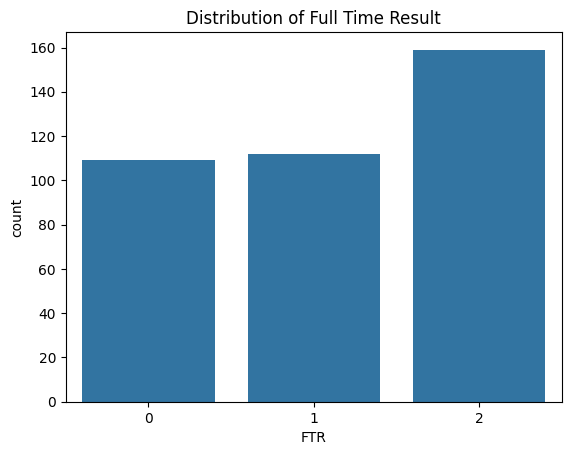

In [31]:
# EDA
# Distribution of target variable
sns.countplot(x='FTR', data=df)
plt.title('Distribution of Full Time Result')
plt.show()

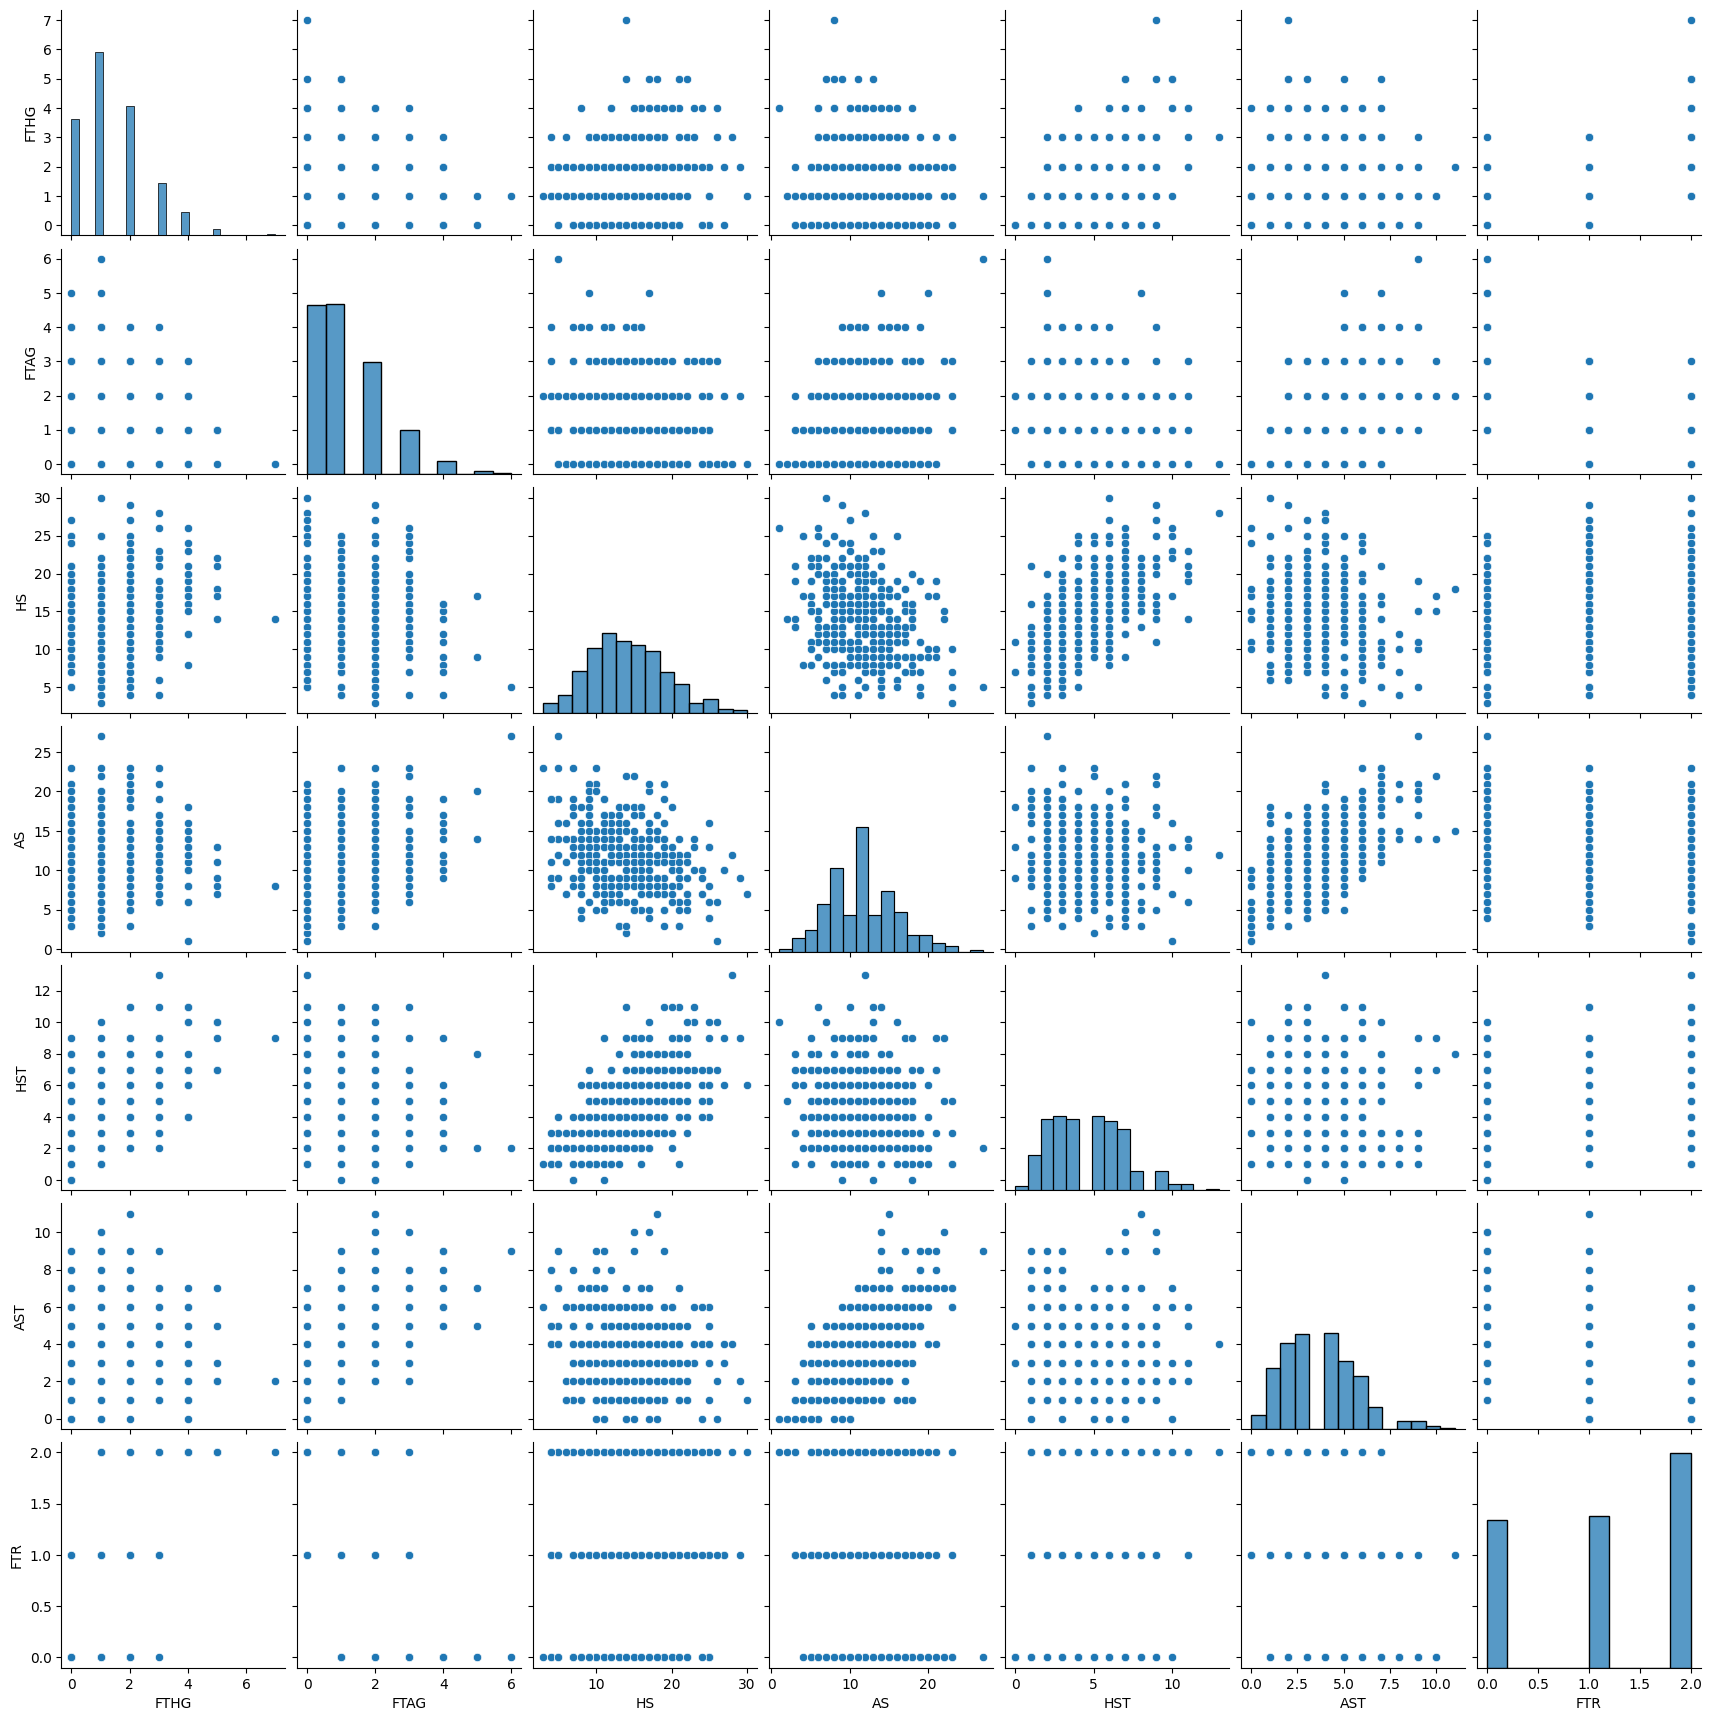

In [32]:
# Pairplot for some features
sns.pairplot(df[['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'FTR']])
plt.show()

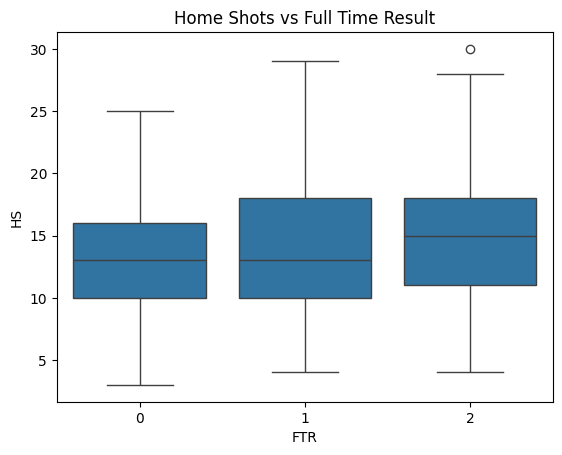

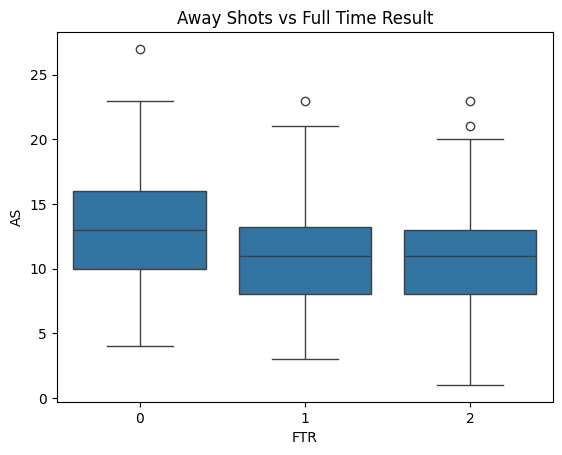

In [33]:
# Boxplot for Home vs Away Shots
sns.boxplot(x='FTR', y='HS', data=df)
plt.title('Home Shots vs Full Time Result')
plt.show()
sns.boxplot(x='FTR', y='AS', data=df)
plt.title('Away Shots vs Full Time Result')
plt.show()

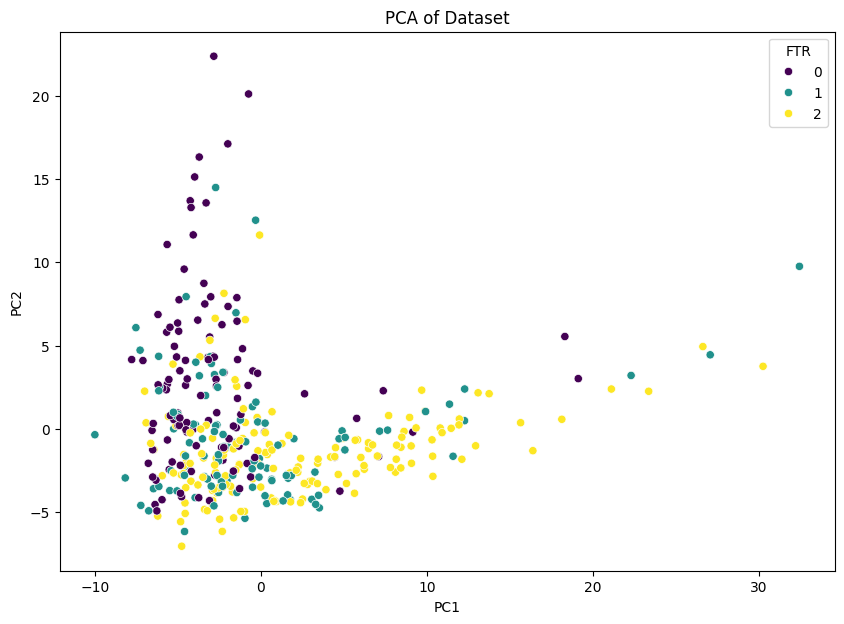

In [34]:
# Separating the features and the target
X = df[numeric_columns]
y = df['FTR']

from sklearn.preprocessing import StandardScaler
X_standardized = StandardScaler().fit_transform(X)

# Performing PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenating the target variable
pc_df = pd.concat([pc_df, y.reset_index(drop=True)], axis=1)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='FTR', data=pc_df, palette='viridis')
plt.title('PCA of Dataset')
plt.show()

<ipython-input-35-a0d9360e99a6>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['Importance'], y=feature_importances.index,


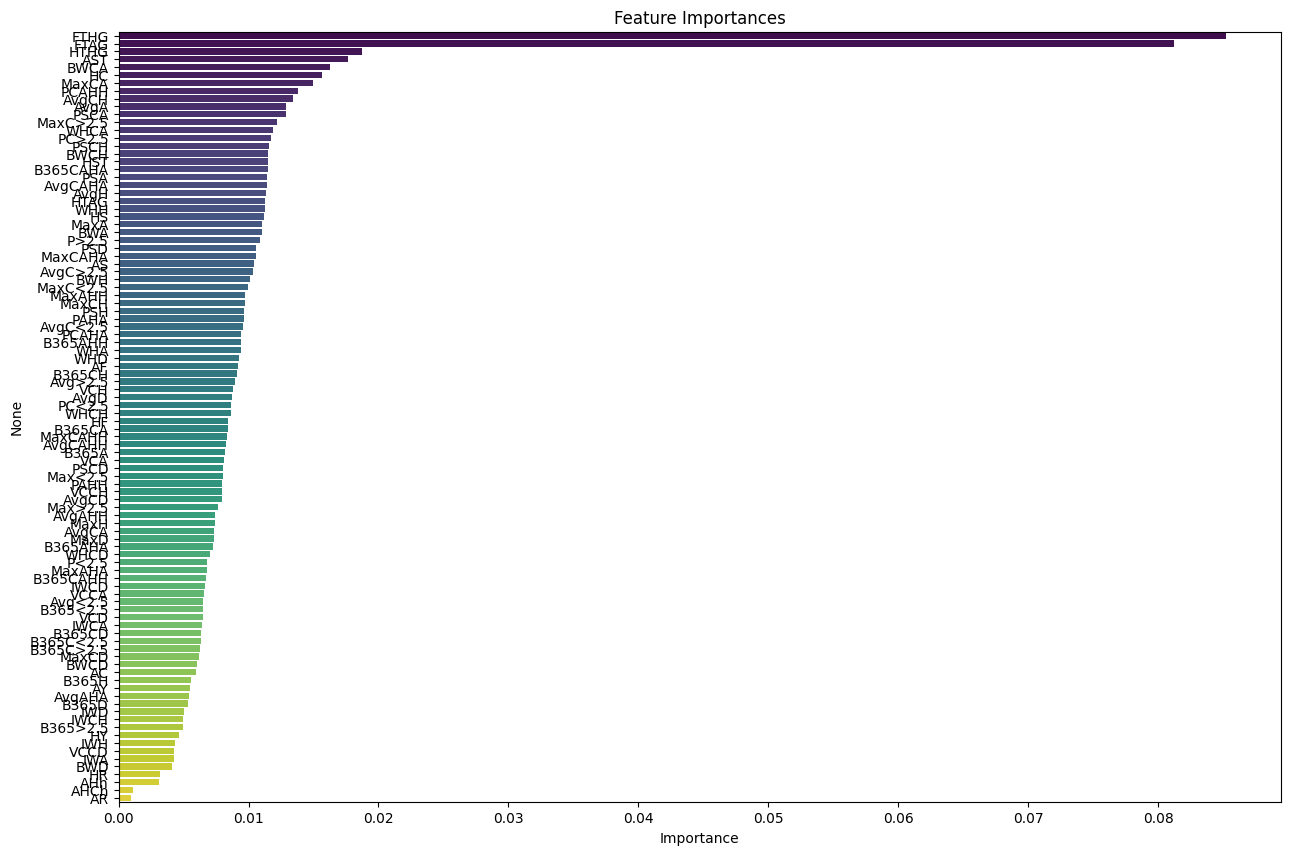

In [35]:
X = df[numeric_columns]
y = df['FTR']
# Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Training a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_encoded)

# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns,
                                   columns=['Importance'])

# Sort feature importances
feature_importances = feature_importances.sort_values('Importance',
                                                      ascending=False)

# Plot feature importances
plt.figure(figsize=(15, 10))
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index,
            palette='viridis')
plt.title('Feature Importances')
plt.show()

In [36]:
# Define the keywords that indicate betting odds columns
betting_keywords = ['B365', 'BW', 'IW', 'PS', 'WH', 'VC', 'Max', 'Avg', 'P>2.5', 'P<2.5', 'AHh', 'AHH', 'AHA', 'CH', 'CD', 'CA', 'C>2.5', 'C<2.5','AHCh']

# Create a list of columns to drop
columns_to_drop = [col for col in df.columns if any(keyword in col for keyword in betting_keywords)]

# Drop the columns
data_cleaned = df.drop(columns=columns_to_drop)

# Display the cleaned data
print(data_cleaned.head())


  Div        Date   Time  HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  \
0  I1  19/08/2023  17:30         3        19     0     1    0     0     0   
1  I1  19/08/2023  17:30         5        13     1     3    0     1     2   
2  I1  19/08/2023  19:45         6         4     1     4    0     0     3   
3  I1  19/08/2023  19:45         7        12     2     0    2     1     0   
4  I1  20/08/2023  17:30        14        15     2     2    1     1     1   

   ...  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0  ...    4    4  17  18   2   4   2   2   0   0  
1  ...    1    8  14  17   4   6   3   3   0   0  
2  ...    2    5  14  13   3   4   2   3   0   0  
3  ...    3    2   8  13   8   3   1   1   0   0  
4  ...    3    2  12   9   9   1   0   4   0   0  

[5 rows x 23 columns]


In [37]:
# Dropping columns that won't be used for prediction
X = data_cleaned.drop(['FTR', 'Date', 'Time', 'Div'], axis=1)
y = data_cleaned['FTR']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters for Random Forest: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 283}
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.033973073466736566, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 259, 'subsample': 0.9037581243486733}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.85      0.92      0.88        25
           2       0.93      0.97      0.95        29

    accuracy                           0.91        76
   macro avg       0.91      0.90      0.90        76
weighted avg       0.91      0.91      0.91        76

Best Gradient Boosting:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      1.00      1.00        25
           2       1.00      0.97      0.98        29

    accuracy                           0.99        76
   macro avg       0.99      0.99      0.99        76
weighted avg       0.99      0.99      0.99        76



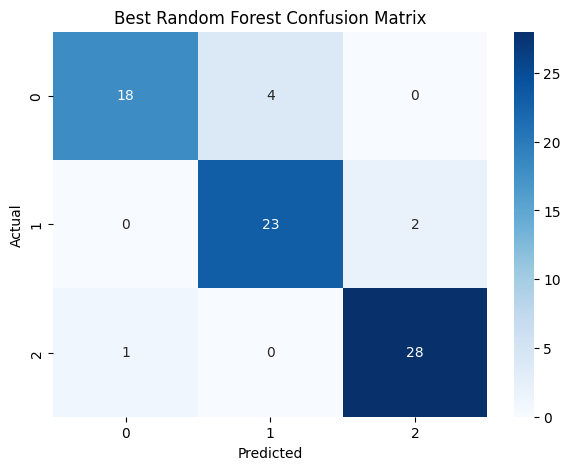

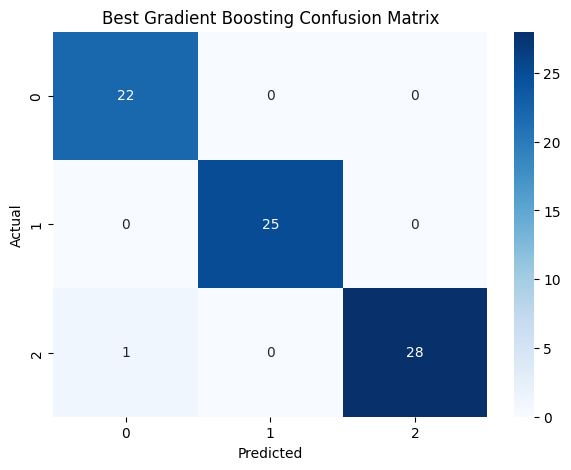

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Defining parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Defining parameter distributions for Gradient Boosting
param_dist_gb = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 6),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'subsample': uniform(0.8, 0.2)
}

# Initialising RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist_rf,
                                      n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Initialising RandomizedSearchCV for Gradient Boosting
random_search_gb = RandomizedSearchCV(estimator=grad_boost, param_distributions=param_dist_gb,
                                      n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Perform random search for Random Forest
random_search_rf.fit(X_train_scaled, y_train)
best_params_rf = random_search_rf.best_params_
print(f"Best parameters for Random Forest: {best_params_rf}")

# Perform random search for Gradient Boosting
random_search_gb.fit(X_train_scaled, y_train)
best_params_gb = random_search_gb.best_params_
print(f"Best parameters for Gradient Boosting: {best_params_gb}")

# Training models with the best parameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_gb = GradientBoostingClassifier(**best_params_gb, random_state=42)

best_rf.fit(X_train_scaled, y_train)
best_gb.fit(X_train_scaled, y_train)

# Making predictions with the best models
y_pred_best_rf = best_rf.predict(X_test_scaled)
y_pred_best_gb = best_gb.predict(X_test_scaled)

# Evaluating the best models
print("Best Random Forest:\n", classification_report(y_test, y_pred_best_rf))
print("Best Gradient Boosting:\n", classification_report(y_test, y_pred_best_gb))

# Confusion Matrix for best models
models = ['Best Random Forest', 'Best Gradient Boosting']
predictions = [y_pred_best_rf, y_pred_best_gb]

for model, y_pred in zip(models, predictions):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
